In [121]:
import sys, os, io
import dvc.api
sys.path.append(os.path.abspath(os.path.join('..')))

In [122]:
from scripts.dataloader import DataLoader
from scripts.exploration import Exploration

In [123]:
train_data = '../data/clean/train.csv'
test_data = '../data/clean/test.csv'
store_data = '../data/clean/store.csv'

### Load the data from Gdrive

In [124]:
dataloader = DataLoader()
exp = Exploration()
repo = 'https://github.com/Haylemicheal/Pharmaceutical-Sales-Prediction/'
content_train =dvc.api.read(path=train_data, repo=repo, rev='cleaned-v')
df_train = dataloader.read_csv(io.StringIO(content_train))
content_store =dvc.api.read(path=store_data, repo=repo, rev='cleaned-v')
df_store = dataloader.read_csv(io.StringIO(content_store))
content_test =dvc.api.read(path=test_data, repo=repo, rev='cleaned-v')
df_test = dataloader.read_csv(io.StringIO(content_test))

In [125]:
df_train[["year","month","day"]] = df_train["Date"].str.split("-", expand = True)
df_test[["year","month","day"]] = df_test["Date"].str.split("-", expand = True)

## Questions

1. Check for distribution in both training and test sets - are the promotions distributed similarly between these two groups?

In [126]:
train_promo = df_train['Promo']
test_promo = df_test['Promo']

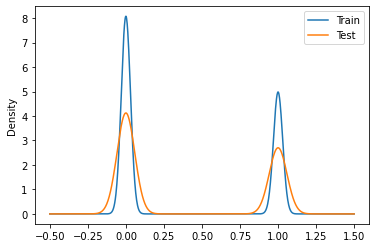

In [127]:
from matplotlib import pyplot
pyplot.figure(1)
pyplot.subplot(111)
train_promo.plot(kind= 'kde' )
pyplot.subplot(111)
test_promo.plot(kind= 'kde')
pyplot.legend(['Train', 'Test'])
pyplot.show()

The distribution of the promo is almost the same in train and test data

### Check & compare sales behavior before, during and after holidays


In [128]:
df_train['StateHoliday'].unique()

array(['0', 'a', 'b', 'c'], dtype=object)

StateHoliday

- 0 -> None
- a -> Public Holiday
- b -> Easter
- c -> Christmass

In [129]:
import pandas as pd
christmas_date = df_train[df_train['StateHoliday'] == 'c']
christmas_dates = christmas_date.groupby('Date')['Date'].unique().index
pd.to_datetime(christmas_dates)

DatetimeIndex(['2013-12-25', '2013-12-26', '2014-12-25', '2014-12-26'], dtype='datetime64[ns]', name='Date', freq=None)

In [130]:
grouped_by_date = df_train.groupby(
    'Date')[['Sales']]
grouped_by_date = grouped_by_date.sum()
grouped_by_date.head()

,Sales
Date,
2013-01-01,97235
2013-01-02,6949829
2013-01-03,6347820
2013-01-04,6638954
2013-01-05,5951593


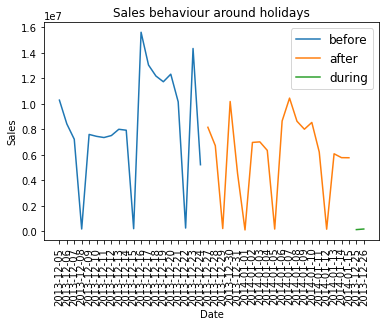

In [131]:
from turtle import color
import seaborn as sns

before_christmass_idx = grouped_by_date[pd.to_datetime(grouped_by_date.index) < christmas_dates[0]].index[-20:]
after_christmass_idx = grouped_by_date[pd.to_datetime(grouped_by_date.index) > christmas_dates[1]].index[:20]
during_christmass_idx = christmas_dates[:2]

before_christmass = grouped_by_date[grouped_by_date.index.isin(before_christmass_idx)]
after_christmass = grouped_by_date[grouped_by_date.index.isin(after_christmass_idx)]
during_christmass = grouped_by_date[grouped_by_date.index.isin(during_christmass_idx)]

# sns.set()
sns.lineplot(x=before_christmass.index, y=before_christmass['Sales'])
sns.lineplot(x=after_christmass.index, y=after_christmass['Sales'])
ax = sns.lineplot(x=during_christmass.index, y=during_christmass['Sales'])
ax.set_title("Sales behaviour around holidays")
pyplot.xticks(rotation=90)
ax.legend(['before', 'after', 'during'], fontsize=12)

The maximum of the sales is happened before the holiday. The lowest Sales is on the Holyday.

### Find out any seasonal (Christmas, Easter etc) purchase behaviors

The Selling pattern every year is similar.

### What can you say about the correlation between sales and number of customers?

Text(0.5, 1.0, 'Correlation between sales and other features')

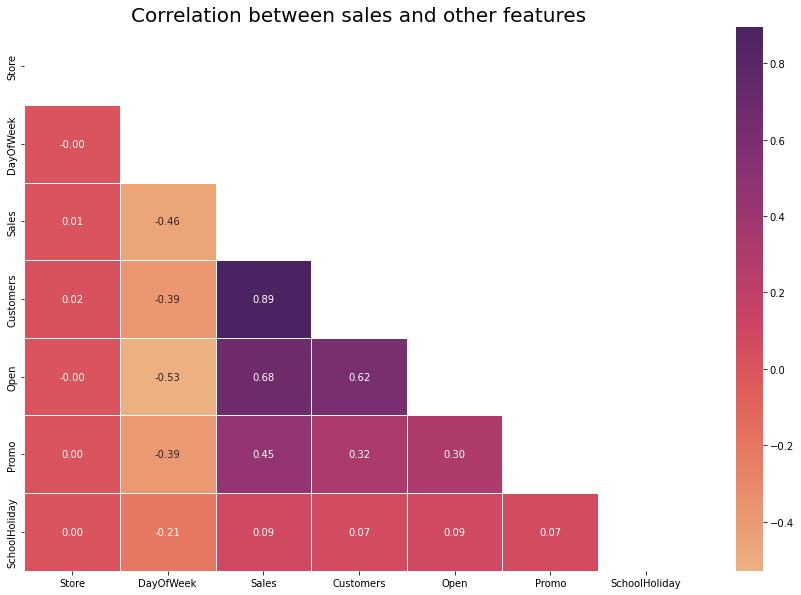

In [132]:
import numpy as np
df_correlation = df_train[['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'day','month','year']]

upper_triangle = np.zeros_like(df_correlation.corr(), dtype=bool)
upper_triangle[np.triu_indices_from(upper_triangle)] = True
f, ax = pyplot.subplots(figsize=(15, 10))
sns.heatmap(df_correlation.corr(),
            ax=ax,
            annot=True,
            mask=upper_triangle,
            fmt='.2f',
            linewidths=0.5,
            cmap=sns.color_palette("flare", as_cmap=True))
ax.set_title("Correlation between sales and other features", fontsize=20)

### How does promo affect sales? Are the promos attracting more customers?

In [133]:
promo = df_train[df_train['Promo'] == 1]
no_promo = df_train[df_train['Promo'] == 0]
sales_with_promo = promo.groupby("month").agg({"Sales":  "mean"})
sales_without_promo = no_promo.groupby("month").agg({"Sales":  "mean"})

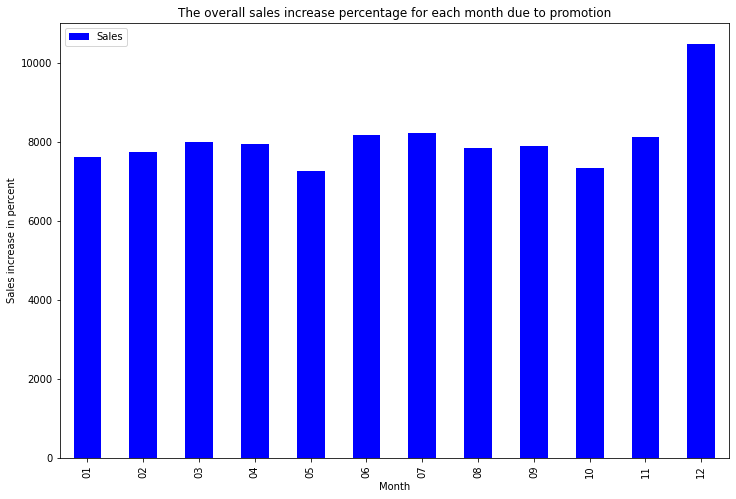

In [134]:
ax = sales_with_promo.plot(kind="bar",color='blue',figsize=(12,8))
ax.set_title("The overall sales increase percentage for each month due to promotion")
ax.set_xlabel("Month")
ax.set_ylabel("Sales increase in percent")
pyplot.show()

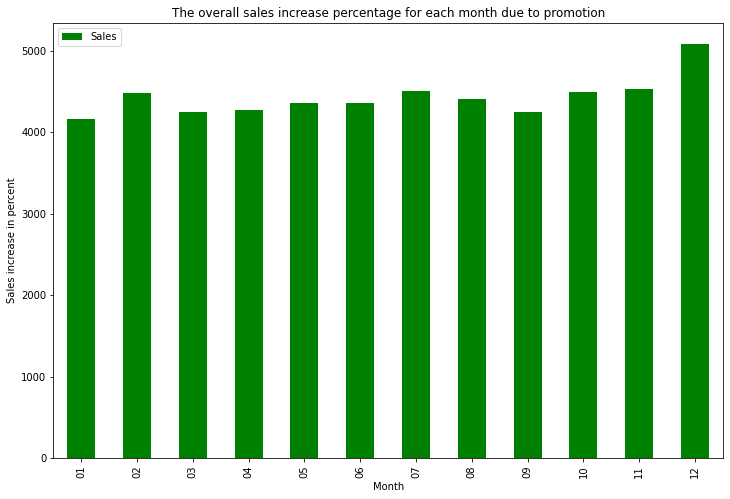

In [135]:
ax = sales_without_promo.plot(kind="bar",color='green',figsize=(12,8))
ax.set_title("The overall sales increase percentage for each month due to promotion")
ax.set_xlabel("Month")
ax.set_ylabel("Sales increase in percent")
pyplot.show()

As we can see from the plots the promotions has a positive effect on the sales.

 ### How does it affect already existing customers?

In [136]:
promo = df_train[df_train['Promo'] == 1]
no_promo = df_train[df_train['Promo'] == 0]
customers_with_promo = promo.groupby("month").agg({"Customers":  "mean"})
customers_without_promo = no_promo.groupby("month").agg({"Customers":  "mean"})

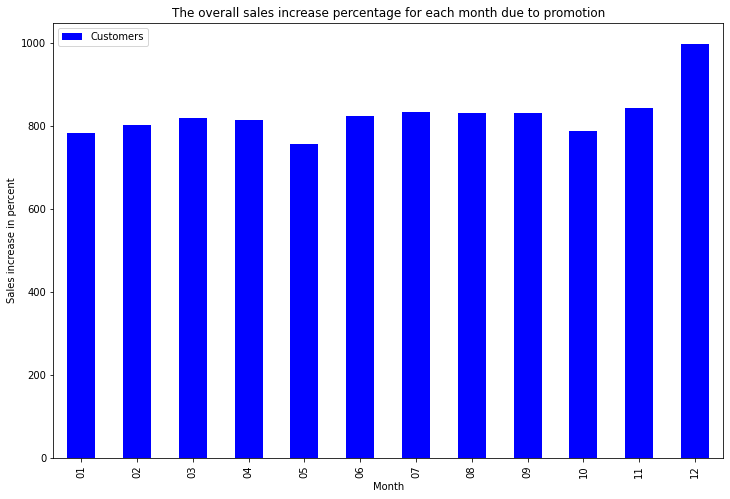

In [137]:
ax = customers_with_promo.plot(kind="bar",color='blue',figsize=(12,8))
ax.set_title("The overall sales increase percentage for each month due to promotion")
ax.set_xlabel("Month")
ax.set_ylabel("Sales increase in percent")
pyplot.show()

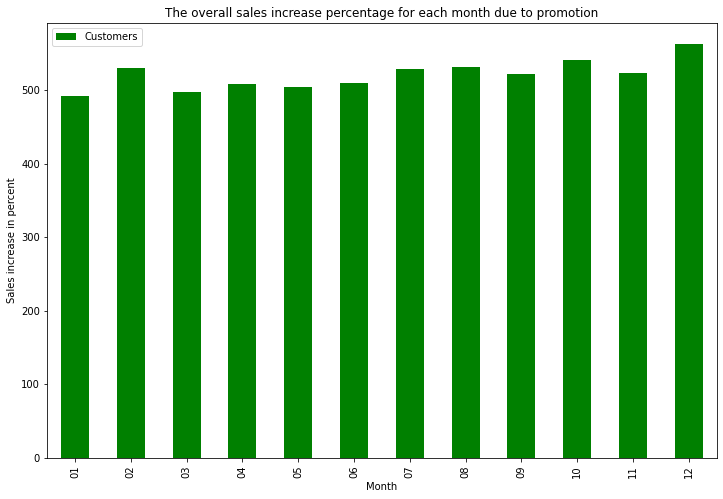

In [138]:
ax = customers_without_promo.plot(kind="bar",color='green',figsize=(12,8))
ax.set_title("The overall sales increase percentage for each month due to promotion")
ax.set_xlabel("Month")
ax.set_ylabel("Sales increase in percent")
pyplot.show()

As we see from the plots the promos has a positive effect on the number of customers.

### Could the promos be deployed in more effective ways? Which stores should promos be deployed in?

In [139]:
df_store.columns

Index(['Unnamed: 0', 'Store', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [140]:
df = df_train.groupby("Store").agg({"Sales":  "sum"}).sort_values(by=['Store'])

In [141]:
df_store

,Unnamed: 0,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,0,1,c,a,1270.0,9.0,2008.0,0,22.0,2012.0,"Jan,Apr,Jul,Oct"
1,1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,3,4,c,c,620.0,9.0,2009.0,0,22.0,2012.0,"Jan,Apr,Jul,Oct"
4,4,5,a,a,29910.0,4.0,2015.0,0,22.0,2012.0,"Jan,Apr,Jul,Oct"
...,...,...,...,...,...,...,...,...,...,...,...
1110,1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1111,1112,c,c,1880.0,4.0,2006.0,0,22.0,2012.0,"Jan,Apr,Jul,Oct"
1112,1112,1113,a,c,9260.0,8.0,2010.0,0,22.0,2012.0,"Jan,Apr,Jul,Oct"
1113,1113,1114,a,c,870.0,8.0,2010.0,0,22.0,2012.0,"Jan,Apr,Jul,Oct"


In [142]:
merged = pd.concat([df, df_store['StoreType']], axis=1)

In [143]:
merged.groupby('StoreType').agg({"Sales":  "sum"})

,Sales
StoreType,
a,3.187921e+09
b,9.672128e+07
c,7.744859e+08
d,1.809130e+09


StoreType A has the biggest sales record. The promotions has a direct impact on the StoreType A.

### Trends of customer behavior during store open and closing times

In [144]:
df_train[df_train['Open'] == 0]

,Unnamed: 0,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,year,month,day
291,291,292,5,2015-07-31,0,0,0,1,0,1,2015,07,31
875,875,876,5,2015-07-31,0,0,0,1,0,1,2015,07,31
1406,1406,292,4,2015-07-30,0,0,0,1,0,1,2015,07,30
1990,1990,876,4,2015-07-30,0,0,0,1,0,1,2015,07,30
2521,2521,292,3,2015-07-29,0,0,0,1,0,1,2015,07,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1017204,1111,2,2013-01-01,0,0,0,0,a,1,2013,01,01
1017205,1017205,1112,2,2013-01-01,0,0,0,0,a,1,2013,01,01
1017206,1017206,1113,2,2013-01-01,0,0,0,0,a,1,2013,01,01
1017207,1017207,1114,2,2013-01-01,0,0,0,0,a,1,2013,01,01


### Which stores are opened on all weekdays? How does that affect their sales on weekends? 

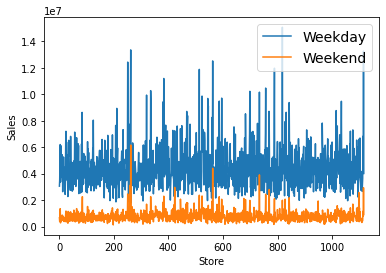

In [145]:
stores_open_on_weekdays = df_train.query("Open==1")['Store'].unique()
sales_stores_open_on_weekdays = df_train[(df_train["Store"].isin(stores_open_on_weekdays) &df_train['Open']==1 & ~df_train['DayOfWeek'].isin([6,7]))].groupby('Store')['Sales'].sum()
sns.lineplot(data=sales_stores_open_on_weekdays)
sales_stores_open_on_weekdays = df_train[(df_train["Store"].isin(stores_open_on_weekdays) & df_train['Open']==1 & df_train['DayOfWeek'].isin([6,7]))].groupby('Store')['Sales'].sum()
sns.lineplot(data=sales_stores_open_on_weekdays)
pyplot.legend(['Weekday', 'Weekend'], fontsize=14, loc='upper right')
pyplot.show()

### Check how the assortment type affects sales

In [146]:
df_assort = df_store[['Assortment','StoreType']]

In [147]:
merged = pd.concat([df, df_assort], axis=1)

In [148]:
merged

,Sales,Assortment,StoreType
1,3716854.0,a,a
2,3883858.0,a,a
3,5408261.0,c,c
4,7556507.0,a,a
5,3642818.0,a,a
...,...,...,...
1112,7974294.0,c,a
1113,5196242.0,c,a
1114,16202585.0,c,d
1115,4922229.0,NaN,NaN


In [149]:
merged.groupby('Assortment').agg({"Sales":  "sum"})

,Sales
Assortment,
a,3.103744e+09
b,4.807877e+07
c,2.716436e+09


The assortment type a has the maximum sales and the minimum sales is happened in the assortment type c

### How does the distance to the next competitor affect sales? What if the store and its competitors all happen to be in city centers, does the distance matter in that case?


,Sales,CompetitionDistance
Sales,1.000000,0.004643
CompetitionDistance,0.004643,1.000000


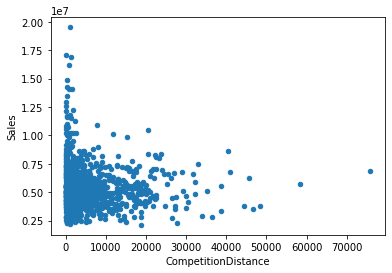

In [150]:
df_ = df_store[['CompetitionDistance','StoreType']]
df_merged = pd.concat([df_train, df_], axis=1)
competition_df = df_merged[["Store", "Sales", "Customers", "StoreType", "CompetitionDistance"]]
competition_df_agg = competition_df.groupby("Store").agg({"Sales": "sum", "Customers" : "sum",
                                                      "CompetitionDistance": lambda x: max(x)})
competition_df_agg.plot(x='CompetitionDistance', y='Sales',kind='scatter')

competition_df_corr = competition_df[["Sales", "CompetitionDistance"]].corr()
display(competition_df_corr)

In [151]:
df_train

,Unnamed: 0,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,year,month,day
0,0,1,5,2015-07-31,5263,555,1,1,0,1,2015,07,31
1,1,2,5,2015-07-31,6064,625,1,1,0,1,2015,07,31
2,2,3,5,2015-07-31,8314,821,1,1,0,1,2015,07,31
3,3,4,5,2015-07-31,13995,1498,1,1,0,1,2015,07,31
4,4,5,5,2015-07-31,4822,559,1,1,0,1,2015,07,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1017204,1111,2,2013-01-01,0,0,0,0,a,1,2013,01,01
1017205,1017205,1112,2,2013-01-01,0,0,0,0,a,1,2013,01,01
1017206,1017206,1113,2,2013-01-01,0,0,0,0,a,1,2013,01,01
1017207,1017207,1114,2,2013-01-01,0,0,0,0,a,1,2013,01,01


In [152]:
merged.to_csv('../data/clean/merged_data.csv')